In [7]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ["GRADIO_SHARE"]="1"
os.environ["WORLD_SIZE"] = "1"

In [8]:
import torch

# CUDA 장치의 주요 버전과 부 버전을 가져옵니다.
major_version, minor_version = torch.cuda.get_device_capability()
major_version, minor_version

(8, 9)

In [9]:
import torch

if torch.cuda.is_available():
    print(f"CUDA available: {torch.cuda.is_available()}")
    print(f"Device count: {torch.cuda.device_count()}")
    print(f"Current device name: {torch.cuda.get_device_name(0)}")
    print(f"Device capability: {torch.cuda.get_device_capability(0)}")
    print(f"bfloat16 support: {torch.cuda.is_bf16_supported()}")
else:
    print("CUDA not available")

CUDA available: True
Device count: 1
Current device name: NVIDIA RTX 6000 Ada Generation
Device capability: (8, 9)
bfloat16 support: True


In [10]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_8bit = False # Use 4bit quantization to reduce memory usage. Can be False.

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "beomi/Llama-3-Open-Ko-8B-Instruct-preview", # Choose ANY! eg teknium/OpenHermes-2.5-Mistral-7B
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_8bit = load_in_8bit,
)

==((====))==  Unsloth: Fast Llama patching release 2024.7
   \\   /|    GPU: NVIDIA RTX 6000 Ada Generation. Max memory: 47.507 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.2.1+cu121. CUDA = 8.9. CUDA Toolkit = 12.1.
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.25. FA2 = True]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth


Loading checkpoint shards: 100%|██████████| 4/4 [00:02<00:00,  1.48it/s]


We now add LoRA adapters so we only need to update 1 to 10% of all parameters!

In [11]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 32,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
)

In [12]:
alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""


EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN

def formatting_prompts_func(examples):
    instructions = examples["instruction"]
    inputs       = examples["input"]
    outputs      = examples["output"]
    texts = []
    for instruction, input, output in zip(instructions, inputs, outputs):
        # Must add EOS_TOKEN, otherwise your generation will go on forever!
        text = alpaca_prompt.format(instruction, input, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }
pass

from datasets import load_dataset
dataset = load_dataset("Bingsu/ko_alpaca_data", split="train")
dataset = dataset.map(formatting_prompts_func, batched = True,)

# 데이터셋을 훈련과 검증 세트로 나누기 (예: 1%를 검증 세트로 사용)
dataset_split = dataset.train_test_split(test_size=0.01, seed=42)

# 훈련 및 검증 데이터셋으로 나누기
train_dataset = dataset_split['train']
valid_dataset = dataset_split['test']

# 데이터셋 정보 출력
print("훈련 데이터셋 크기:", len(train_dataset))
print("검증 데이터셋 크기:", len(valid_dataset))

훈련 데이터셋 크기: 49123
검증 데이터셋 크기: 497


In [13]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

tokenizer.padding_side = "right"  # 토크나이저의 패딩을 오른쪽으로 설정합니다.

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_dataset,
    eval_dataset = valid_dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 1,
        gradient_accumulation_steps = 16,
        warmup_steps = 5,
        max_steps = 300, # Set num_train_epochs = 1 for full training runs
        do_eval=True,
        evaluation_strategy="steps",
        logging_steps=1,  # logging 스텝 수
        learning_rate = 2e-5,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "cosine",
        seed = 3407,
        output_dir = "outputs",
    ),
)

/home/ragllama/.conda/envs/kollm/lib/python3.11/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/home/ragllama/.conda/envs/kollm/lib/python3.11/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/home/ragllama/.conda/envs/kollm/lib/python3.11/site-packages/transformers/training_args.py:1961: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(
/home/ragllama/.conda/envs/kollm/lib/python3.11/site-packages/trl/trainer/sft_trainer.py:269: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
/home/raglla

In [15]:
#@title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA RTX 6000 Ada Generation. Max memory = 47.507 GB.
11.084 GB of memory reserved.


In [16]:
#     
trainer_stats = trainer.train()

********************
Unsloth currently does not work on multi GPU setups - sadly we are a 2 brother team so enabling it will require much more work, so we have to prioritize. Please understand!
********************
We do have a separate beta version, which you can contact us about!
********************
Thank you for your understanding and we appreciate it immensely!


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 49,123 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 1 | Gradient Accumulation steps = 16
\        /    Total batch size = 16 | Total steps = 300
 "-____-"     Number of trainable parameters = 41,943,040


********************
Unsloth currently does not work on multi GPU setups - sadly we are a 2 brother team so enabling it will require much more work, so we have to prioritize. Please understand!
********************
We do have a separate beta version, which you can contact us about!
********************
Thank you for your understanding and we appreciate it immensely!


Step,Training Loss,Validation Loss
1,3.276000,3.034699
2,3.269300,3.034437
3,2.949900,3.026199
4,2.940000,3.007372
5,3.110600,2.962869
6,3.113300,2.885751
7,2.937400,2.792133
8,2.796200,2.693232
9,2.530900,2.595236
10,2.642000,2.501951


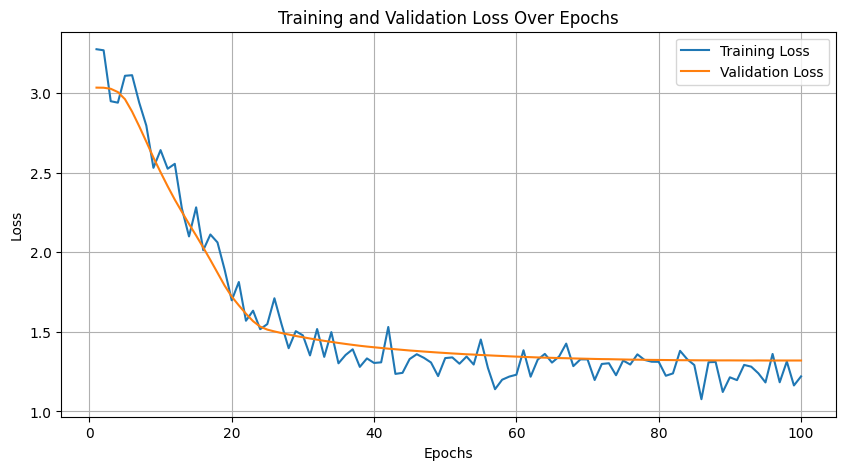

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(trainer.state.log_history)

train_loss = df ['loss'].dropna()
val_loss = df ['eval_loss'].dropna()

epochs = range(1, len(train_loss) + 1)

# 그래프 그리기
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
#@title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory         /max_memory*100, 3)
lora_percentage = round(used_memory_for_lora/max_memory*100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training.")
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

1399.846 seconds used for training.
23.33 minutes used for training.
Peak reserved memory = 10.139 GB.
Peak reserved memory for training = 4.526 GB.
Peak reserved memory % of max memory = 21.342 %.
Peak reserved memory for training % of max memory = 9.527 %.


<a name="Inference"></a>
### Inference
Let's run the model! You can change the instruction and input - leave the output blank!

In [ ]:
# alpaca_prompt = Copied from above
FastLanguageModel.for_inference(model) # Enable native 2x faster inference
inputs = tokenizer(
[
    alpaca_prompt.format(
        "Continue the fibonnaci sequence.", # instruction
        "1, 1, 2, 3, 5, 8", # input
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 64, use_cache = True)
tokenizer.batch_decode(outputs)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


['<s> Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\nContinue the fibonnaci sequence.\n\n### Input:\n1, 1, 2, 3, 5, 8\n\n### Response:\n13, 21, 34, 55, 89, 144</s>']

 You can also use a `TextStreamer` for continuous inference - so you can see the generation token by token, instead of waiting the whole time!

In [ ]:
# alpaca_prompt = Copied from above
FastLanguageModel.for_inference(model) # Enable native 2x faster inference
inputs = tokenizer(
[
    alpaca_prompt.format(
        "Continue the fibonnaci sequence.", # instruction
        "1, 1, 2, 3, 5, 8", # input
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


<s> Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
Continue the fibonnaci sequence.

### Input:
1, 1, 2, 3, 5, 8

### Response:
13, 21, 34, 55, 89, 144</s>


<a name="Save"></a>
### Saving, loading finetuned models
To save the final model as LoRA adapters, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model. To save to 16bit or GGUF, scroll down!

In [23]:
model.save_pretrained("lora_model") # Local saving
tokenizer.save_pretrained("lora_model")
# model.push_to_hub("your_name/lora_model", token = "...") # Online saving
# tokenizer.push_to_hub("your_name/lora_model", token = "...") # Online saving

('lora_model/tokenizer_config.json',
 'lora_model/special_tokens_map.json',
 'lora_model/tokenizer.json')

Now if you want to load the LoRA adapters we just saved for inference, set `False` to `True`:

In [ ]:
if False:
    from unsloth import FastLanguageModel
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        max_seq_length = max_seq_length,
        dtype = dtype,
        load_in_4bit = load_in_4bit,
    )
    FastLanguageModel.for_inference(model) # Enable native 2x faster inference

# alpaca_prompt = You MUST copy from above!

inputs = tokenizer(
[
    alpaca_prompt.format(
        "What is a famous tall tower in Paris?", # instruction
        "", # input
        "", # output - leave this blank for generation!
    ),
], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 64, use_cache = True)
tokenizer.batch_decode(outputs)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


["<s> Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\nWhat is a famous tall tower in Paris?\n\n### Input:\n\n\n### Response:\nThe Eiffel Tower is a famous tall tower in Paris, France. It is located on the Champ de Mars and is one of the most recognizable structures in the world. The tower was built in 1889 as the entrance arch to the 1889 World's Fair and was"]

You can also use Hugging Face's `AutoModelForPeftCausalLM`. Only use this if you do not have `unsloth` installed. It can be hopelessly slow, since `4bit` model downloading is not supported, and Unsloth's **inference is 2x faster**.

In [ ]:
if False:
    # I highly do NOT suggest - use Unsloth if possible
    from peft import AutoPeftModelForCausalLM
    from transformers import AutoTokenizer
    model = AutoPeftModelForCausalLM.from_pretrained(
        "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        load_in_4bit = load_in_4bit,
    )
    tokenizer = AutoTokenizer.from_pretrained("lora_model")

### Saving to float16 for VLLM

We also support saving to `float16` directly. Select `merged_16bit` for float16 or `merged_4bit` for int4. We also allow `lora` adapters as a fallback. Use `push_to_hub_merged` to upload to your Hugging Face account! You can go to https://huggingface.co/settings/tokens for your personal tokens.

In [ ]:
# Merge to 16bit
if False: model.save_pretrained_merged("model", tokenizer, save_method = "merged_16bit",)
if False: model.push_to_hub_merged("hf/model", tokenizer, save_method = "merged_16bit", token = "")

# Merge to 4bit
if False: model.save_pretrained_merged("model", tokenizer, save_method = "merged_4bit",)
if False: model.push_to_hub_merged("hf/model", tokenizer, save_method = "merged_4bit", token = "")

# Just LoRA adapters
if False: model.save_pretrained_merged("model", tokenizer, save_method = "lora",)
if False: model.push_to_hub_merged("hf/model", tokenizer, save_method = "lora", token = "")

### GGUF / llama.cpp Conversion
To save to `GGUF` / `llama.cpp`, we support it natively now! We clone `llama.cpp` and we default save it to `q8_0`. We allow all methods like `q4_k_m`. Use `save_pretrained_gguf` for local saving and `push_to_hub_gguf` for uploading to HF.

Some supported quant methods (full list on our [Wiki page](https://github.com/unslothai/unsloth/wiki#gguf-quantization-options)):
* `q8_0` - Fast conversion. High resource use, but generally acceptable.
* `q4_k_m` - Recommended. Uses Q6_K for half of the attention.wv and feed_forward.w2 tensors, else Q4_K.
* `q5_k_m` - Recommended. Uses Q6_K for half of the attention.wv and feed_forward.w2 tensors, else Q5_K.

In [ ]:
# Save to 8bit Q8_0
if False: model.save_pretrained_gguf("model", tokenizer,)
if False: model.push_to_hub_gguf("hf/model", tokenizer, token = "")

# Save to 16bit GGUF
if False: model.save_pretrained_gguf("model", tokenizer, quantization_method = "f16")
if False: model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "f16", token = "")

# Save to q4_k_m GGUF
if False: model.save_pretrained_gguf("model", tokenizer, quantization_method = "q4_k_m")
if False: model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "q4_k_m", token = "")
if False: model.push_to_hub_gguf("hf/model", tokenizer, quantization_method = "q5_k_m", token = "")

Now, use the `model-unsloth.gguf` file or `model-unsloth-Q4_K_M.gguf` file in `llama.cpp` or a UI based system like `GPT4All`. You can install GPT4All by going [here](https://gpt4all.io/index.html).

And we're done! If you have any questions on Unsloth, we have a [Discord](https://discord.gg/u54VK8m8tk) channel! If you find any bugs or want to keep updated with the latest LLM stuff, or need help, join projects etc, feel free to join our Discord!

Some other links:
1. Zephyr DPO 2x faster [free Colab](https://colab.research.google.com/drive/15vttTpzzVXv_tJwEk-hIcQ0S9FcEWvwP?usp=sharing)
2. Llama 7b 2x faster [free Colab](https://colab.research.google.com/drive/1lBzz5KeZJKXjvivbYvmGarix9Ao6Wxe5?usp=sharing)
3. TinyLlama 4x faster full Alpaca 52K in 1 hour [free Colab](https://colab.research.google.com/drive/1AZghoNBQaMDgWJpi4RbffGM1h6raLUj9?usp=sharing)
4. CodeLlama 34b 2x faster [A100 on Colab](https://colab.research.google.com/drive/1y7A0AxE3y8gdj4AVkl2aZX47Xu3P1wJT?usp=sharing)
5. Mistral 7b [free Kaggle version](https://www.kaggle.com/code/danielhanchen/kaggle-mistral-7b-unsloth-notebook)
6. We also did a [blog](https://huggingface.co/blog/unsloth-trl) with 🤗 HuggingFace, and we're in the TRL [docs](https://huggingface.co/docs/trl/main/en/sft_trainer#accelerate-fine-tuning-2x-using-unsloth)!
7. `ChatML` for ShareGPT datasets, [conversational notebook](https://colab.research.google.com/drive/1Aau3lgPzeZKQ-98h69CCu1UJcvIBLmy2?usp=sharing)
8. Text completions like novel writing [notebook](https://colab.research.google.com/drive/1ef-tab5bhkvWmBOObepl1WgJvfvSzn5Q?usp=sharing)
9. Gemma 6 trillion tokens is 2.5x faster! [free Colab](https://colab.research.google.com/drive/10NbwlsRChbma1v55m8LAPYG15uQv6HLo?usp=sharing)

<div class="align-center">
  <a href="https://github.com/unslothai/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
  <a href="https://discord.gg/u54VK8m8tk"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord.png" width="145"></a>
  <a href="https://ko-fi.com/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Kofi button.png" width="145"></a></a> Support our work if you can! Thanks!
</div>